In [1]:
SKIP_TRAINING = False  # Set to True to skip the training loop

import warnings

from pathlib import Path
import numpy as np
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import cv2

from src.degradations import generate_degraded_dataset_auto
from src.losses.combined_loss import CombinedLoss
from src.models.denoising_autoencoder import DenoisingAutoencoder
from src.training import get_dataloaders, run_training
from src.utils import (
    load_checkpoint,
    plot_image_comparison,
    plot_inference_results,
    plot_training_curves,
    print_training_summary,
    setup_or_resume_experiment,
    resume_training,
    download_div2k_dataset,
)
from src.evaluation import ImageRestorationEvaluator

warnings.filterwarnings("ignore")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1650 Ti
CUDA memory: 4.29 GB


## Experiment Configuration

In [ ]:
# Training configuration
config = {
    # Resume Training
    "resume_from_checkpoint": False,
    "resume_experiment": "latest", 
    # Training
    "batch_size": 10,
    "num_epochs": 200,  
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    # Data
    "patch_size": 128, # TRY 256, might need 1 more pass
    "patches_per_image": 2,
    "num_workers": 4,  
    # Model
    "model_name": "denoising_autoencoder",
    "model_features": 64,
    # Loss
    "loss_alpha": 0.84,
    "loss_beta": 0.16,
    # Degradation - Gaussian Noise
    "degradation_type": "gaussian_noise",
    "noise_sigma": 100.0, 
    # Optimization
    "scheduler": "cosine",
    "warmup_epochs": 3,  
    "min_lr": 1e-6,
    # Early stopping
    "patience": 10,
    # Checkpoints
    "save_every": 5,  #
    "val_every": 5,  # 
    # Mixed Precision
    "use_amp": True,  # Keep enabled for faster training
    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}

# Set seed for reproducibility
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

print("\n📋 Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")


📋 Configuration:
   resume_from_checkpoint: False
   resume_experiment: latest
   batch_size: 10
   num_epochs: 200
   learning_rate: 0.0001
   weight_decay: 1e-05
   patch_size: 128
   patches_per_image: 2
   num_workers: 4
   model_name: denoising_autoencoder
   model_features: 64
   loss_alpha: 0.84
   loss_beta: 0.16
   degradation_type: gaussian_noise
   noise_sigma: 100.0
   scheduler: cosine
   warmup_epochs: 3
   min_lr: 1e-06
   patience: 10
   save_every: 5
   val_every: 5
   use_amp: True
   device: cuda
   seed: 42


## Output Directories

In [3]:
exp_dir, checkpoints_dir, samples_dir, logs_dir = setup_or_resume_experiment(
    model_name=config["model_name"],
    degradation="gaussian",
    config=config,
    resume_from_checkpoint=config["resume_from_checkpoint"],
    resume_experiment=config["resume_experiment"],
    custom_name="autoencoder_gaussian",
)


📁 Experiment: 20260109_120451_autoencoder_gaussian


## Tensor Board

In [4]:
# TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

print(f"\n📊 TensorBoard logs: {logs_dir}")
print(f"   Run: tensorboard --logdir {logs_dir.absolute()}")


📊 TensorBoard logs: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\logs
   Run: tensorboard --logdir c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\logs


## Generate Degraded Dataset

In [5]:
# Generate degraded datasets (auto-checks if already exists)
print("=" * 80)
print("🎨 Generating/Loading Degraded Datasets")
print("=" * 80)
print(f"Degradation: Gaussian Noise (σ={config['noise_sigma']})")
print(f"Auto-path: data/degraded/gaussian/sigma_{int(config['noise_sigma'])}/\n")

# Training dataset
train_degraded_dir, train_clean_dir = generate_degraded_dataset_auto(
    dataset_split="DIV2K_train_HR",
    degradation_type="gaussian_noise",
    noise_sigma=config["noise_sigma"],
    seed=config["seed"],
)

# Validation dataset
val_degraded_dir, val_clean_dir = generate_degraded_dataset_auto(
    dataset_split="DIV2K_valid_HR",
    degradation_type="gaussian_noise",
    noise_sigma=config["noise_sigma"],
    seed=config["seed"],
)

# Add paths to config for dataloaders
config["train_degraded_dir"] = str(train_degraded_dir)
config["train_clean_dir"] = str(train_clean_dir)
config["val_degraded_dir"] = str(val_degraded_dir)
config["val_clean_dir"] = str(val_clean_dir)

print("=" * 80)
print("✅ Datasets ready!")
print("=" * 80)

🎨 Generating/Loading Degraded Datasets
Degradation: Gaussian Noise (σ=100.0)
Auto-path: data/degraded/gaussian/sigma_100/

✅ Datasets ready!


## Create Dataloaders

In [6]:
# Create dataloaders
train_loader, val_loader = get_dataloaders(
    train_degraded_dir=config["train_degraded_dir"],
    train_clean_dir=config["train_clean_dir"],
    val_degraded_dir=config["val_degraded_dir"],
    val_clean_dir=config["val_clean_dir"],
    batch_size=config["batch_size"],
    patch_size=config["patch_size"],
    patches_per_image=config["patches_per_image"],
    num_workers=config["num_workers"],
)

print(f"\n   Batches per epoch: {len(train_loader)} train, {len(val_loader)} val")

Loaded 800 valid images for train set
Loaded 100 valid images for val set
📊 Dataset Summary:
   Train: 1600 patches from 800 images
   Val:   200 patches from 100 images
   Batch size: 10
   Patch size: 128x128

   Batches per epoch: 160 train, 20 val


## Visualize Data

Batch shapes:
   Degraded: torch.Size([10, 3, 128, 128])
   Clean: torch.Size([10, 3, 128, 128])
   Range: [-1.000, 1.000]


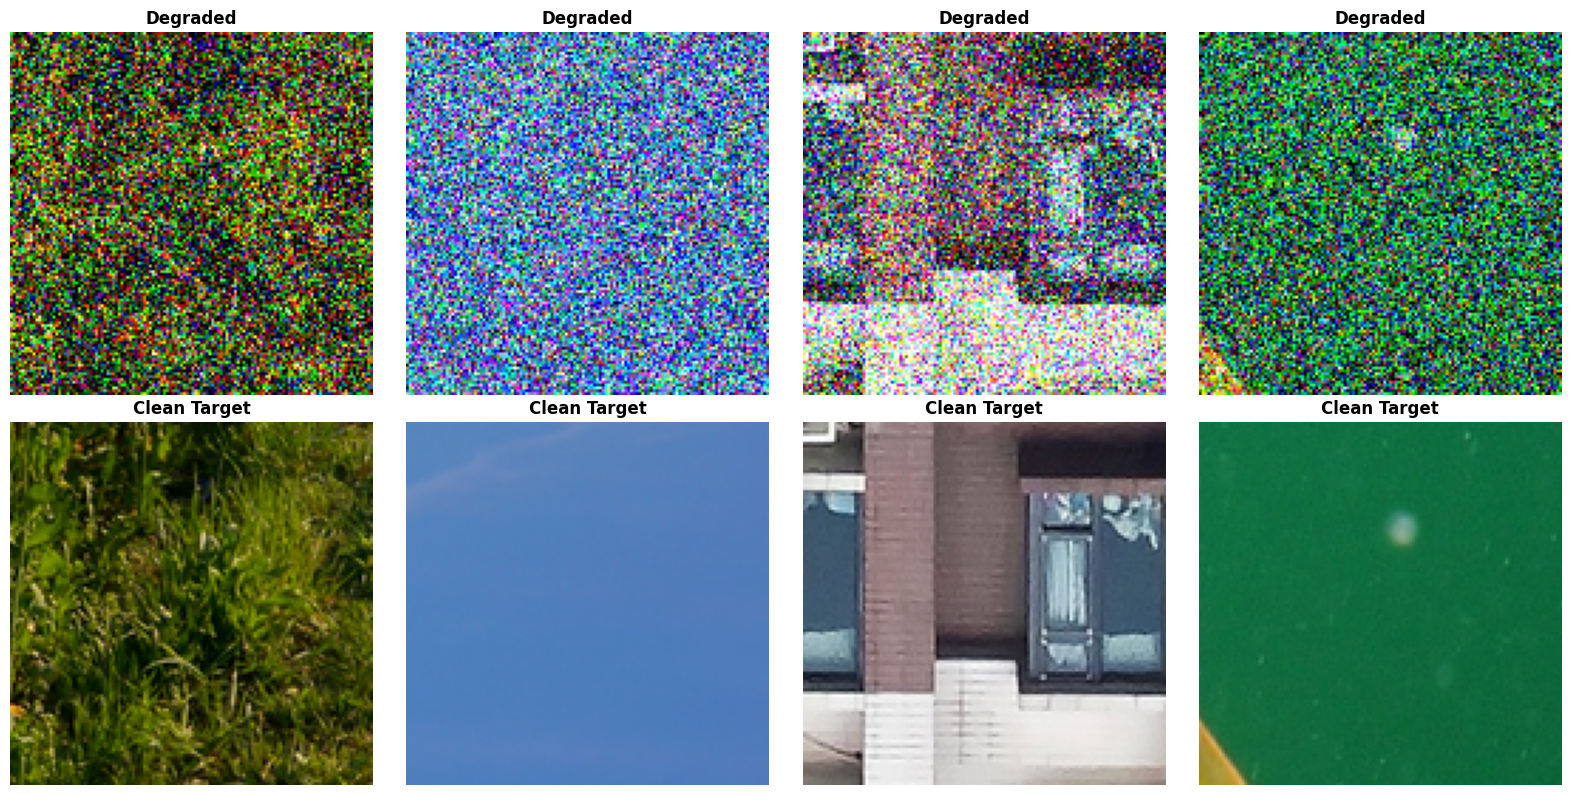


✅ Sample batch saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\samples\training_samples.png


In [7]:
# Visualize a batch
degraded_batch, clean_batch = next(iter(train_loader))

print("Batch shapes:")
print(f"   Degraded: {degraded_batch.shape}")
print(f"   Clean: {clean_batch.shape}")
print(f"   Range: [{degraded_batch.min():.3f}, {degraded_batch.max():.3f}]")

# Show sample using utility function
plot_image_comparison(
    degraded_batch=degraded_batch,
    clean_batch=clean_batch,
    n_samples=4,
    save_path=samples_dir / "training_samples.png",
)

print(f"\n✅ Sample batch saved to {samples_dir / 'training_samples.png'}")

# Initialize Model, Loss and Optimizer

In [8]:
# Create model
model = DenoisingAutoencoder(features=config["model_features"]).to(config["device"])

print("\n🤖 Model: DenoisingAutoencoder")
print(f"   Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"   Device: {config['device']}")

# Loss function
criterion = CombinedLoss(alpha=config["loss_alpha"], beta=config["loss_beta"]).to(
    config["device"]
)

print(f"\n📉 Loss: L1 + SSIM (α={config['loss_alpha']}, β={config['loss_beta']})")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

print("\n⚙️  Optimizer: AdamW")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Weight decay: {config['weight_decay']}")

# Learning rate scheduler
scheduler = None
if config["scheduler"] == "cosine":
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config["num_epochs"] - config["warmup_epochs"],
        eta_min=config["min_lr"],
    )
    print("\n📅 Scheduler: CosineAnnealingLR")
    print(f"   Warmup epochs: {config['warmup_epochs']}")
    print(f"   Min LR: {config['min_lr']}")
else:
    print("\n📅 No scheduler configured")

# Resume from checkpoint if enabled
start_epoch = 0
initial_best_loss = float("inf")
initial_best_epoch = 0
initial_history = None

if config["resume_from_checkpoint"]:
    (
        checkpoint_info,
        start_epoch,
        initial_history,
        exp_dir,
        initial_best_epoch,
    ) = resume_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        experiment_path=config["resume_experiment"],
        model_name=config["model_name"],
        degradation="gaussian",
        device=config["device"],
    )
    initial_best_loss = (
        checkpoint_info["metrics"].get("val", {}).get("loss", float("inf"))
    )
else:
    print("\n🆕 Starting fresh training (resume_from_checkpoint=False)")


🤖 Model: DenoisingAutoencoder
   Parameters: 3102851
   Device: cuda

📉 Loss: L1 + SSIM (α=0.84, β=0.16)

⚙️  Optimizer: AdamW
   Learning rate: 0.0001
   Weight decay: 1e-05

📅 Scheduler: CosineAnnealingLR
   Warmup epochs: 3
   Min LR: 1e-06

🆕 Starting fresh training (resume_from_checkpoint=False)


## Training Loop

In [9]:
if not SKIP_TRAINING:
    # Run training
    history, best_info = run_training(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=config["device"],
        num_epochs=config["num_epochs"],
        checkpoints_dir=checkpoints_dir,
        writer=writer,
        warmup_epochs=config["warmup_epochs"],
        learning_rate=config["learning_rate"],
        patience=config["patience"],
        save_every=config["save_every"],
        val_every=config["val_every"],
        start_epoch=start_epoch,
        initial_best_loss=initial_best_loss,
        initial_best_epoch=initial_best_epoch,  # Pass best epoch from checkpoint
        initial_history=initial_history,  # Continue from previous history
        use_amp=config["use_amp"],  # Enable mixed precision training
        config=config,
    )

    # Extract best model info
    best_epoch = best_info["best_epoch"]
    best_val_loss = best_info["best_val_loss"]

    print(f"✅ Training history saved to {exp_dir / 'history.json'}")
else:
    # Skip training: Load existing history and best model info
    print("\n" + "=" * 80)
    print("⏭️  SKIP_TRAINING = True: Loading existing results")
    print("=" * 80 + "\n")

    from src.utils.experiment import load_training_history

    try:
        history = load_training_history(exp_dir)
        print(f"✅ Loaded history from {exp_dir / 'history.json'}")
        print(f"   Total epochs: {len(history['train_loss'])}")

        # Find best epoch from history
        if history.get("val_loss"):
            # Filter out None values (epochs without validation)
            val_losses = [
                (i, loss)
                for i, loss in enumerate(history["val_loss"])
                if loss is not None
            ]
            if val_losses:
                best_epoch, best_val_loss = min(val_losses, key=lambda x: x[1])
                best_epoch += 1  # Convert to 1-indexed
                print(f"   Best epoch: {best_epoch} (val_loss: {best_val_loss:.4f})")
            else:
                best_val_loss = float("inf")
                best_epoch = 0
                print("   No validation history found")
        else:
            best_val_loss = float("inf")
            best_epoch = 0
            print("   No validation history found")

        # Create best_info dict for consistency
        best_info = {"best_epoch": best_epoch, "best_val_loss": best_val_loss}

    except FileNotFoundError:
        print(f"⚠️  No history found in {exp_dir}")
        print("   Creating empty history (train first to generate data)")
        history = {
            "train_loss": [],
            "train_l1": [],
            "train_ssim": [],
            "val_loss": [],
            "val_l1": [],
            "val_ssim": [],
            "lr": [],
        }
        best_epoch = 0
        best_val_loss = float("inf")
        best_info = {"best_epoch": best_epoch, "best_val_loss": best_val_loss}

    print("=" * 80 + "\n")

⚡ Mixed Precision Training: ENABLED (fp16)

🚀 Starting Training
   Epochs: 1 to 200



📊 Overall Progress:   0%|          | 0/200 epochs [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 1/200
  Train - Loss: 0.4381 | L1: 0.3477 | SSIM: 0.087
  LR: 0.000033 | Time: 58.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 2/200
  Train - Loss: 0.3239 | L1: 0.2325 | SSIM: 0.196
  LR: 0.000067 | Time: 58.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 3 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 3/200
  Train - Loss: 0.2751 | L1: 0.1955 | SSIM: 0.307
  LR: 0.000100 | Time: 57.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 4 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 4/200
  Train - Loss: 0.2571 | L1: 0.1829 | SSIM: 0.353
  LR: 0.000100 | Time: 57.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 5 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 5 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 5/200
  Train - Loss: 0.2516 | L1: 0.1793 | SSIM: 0.369
  Val   - Loss: 0.2235 | L1: 0.1467 | SSIM: 0.373
  LR: 0.000100 | Time: 72.1s (inference: 15.3s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.2235)
  💾 Checkpoint saved (epoch 5)
--------------------------------------------------------------------------------


Epoch 6 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 6/200
  Train - Loss: 0.2361 | L1: 0.1653 | SSIM: 0.392
  LR: 0.000100 | Time: 56.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 7 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 7/200
  Train - Loss: 0.2367 | L1: 0.1668 | SSIM: 0.396
  LR: 0.000100 | Time: 57.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 8 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 8/200
  Train - Loss: 0.2286 | L1: 0.1598 | SSIM: 0.410
  LR: 0.000100 | Time: 57.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 9 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 9/200
  Train - Loss: 0.2209 | L1: 0.1538 | SSIM: 0.427
  LR: 0.000100 | Time: 56.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 10 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 10 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 10/200
  Train - Loss: 0.2225 | L1: 0.1551 | SSIM: 0.424
  Val   - Loss: 0.1924 | L1: 0.1229 | SSIM: 0.443
  LR: 0.000100 | Time: 66.7s (inference: 9.5s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1924)
  💾 Checkpoint saved (epoch 10)
--------------------------------------------------------------------------------


Epoch 11 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 11/200
  Train - Loss: 0.2165 | L1: 0.1493 | SSIM: 0.430
  LR: 0.000100 | Time: 57.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 12 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 12/200
  Train - Loss: 0.2113 | L1: 0.1442 | SSIM: 0.437
  LR: 0.000099 | Time: 57.2s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 13 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 13/200
  Train - Loss: 0.2144 | L1: 0.1478 | SSIM: 0.436
  LR: 0.000099 | Time: 58.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 14 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 14/200
  Train - Loss: 0.2099 | L1: 0.1431 | SSIM: 0.440
  LR: 0.000099 | Time: 57.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 15 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 15 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 15/200
  Train - Loss: 0.2089 | L1: 0.1425 | SSIM: 0.442
  Val   - Loss: 0.1879 | L1: 0.1217 | SSIM: 0.464
  LR: 0.000099 | Time: 66.7s (inference: 9.5s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1879)
  💾 Checkpoint saved (epoch 15)
--------------------------------------------------------------------------------


Epoch 16 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 16/200
  Train - Loss: 0.2085 | L1: 0.1416 | SSIM: 0.440
  LR: 0.000099 | Time: 57.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 17 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 17/200
  Train - Loss: 0.2045 | L1: 0.1386 | SSIM: 0.450
  LR: 0.000099 | Time: 58.3s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 18 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 18/200
  Train - Loss: 0.2044 | L1: 0.1388 | SSIM: 0.451
  LR: 0.000099 | Time: 58.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 19 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 19/200
  Train - Loss: 0.2017 | L1: 0.1371 | SSIM: 0.459
  LR: 0.000098 | Time: 57.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 20 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 20 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 20/200
  Train - Loss: 0.2020 | L1: 0.1363 | SSIM: 0.453
  Val   - Loss: 0.1747 | L1: 0.1095 | SSIM: 0.483
  LR: 0.000098 | Time: 82.4s (inference: 12.3s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1747)
  💾 Checkpoint saved (epoch 20)
--------------------------------------------------------------------------------


Epoch 21 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 21/200
  Train - Loss: 0.1980 | L1: 0.1325 | SSIM: 0.458
  LR: 0.000098 | Time: 72.3s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 22 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 22/200
  Train - Loss: 0.1979 | L1: 0.1326 | SSIM: 0.459
  LR: 0.000098 | Time: 71.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 23 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 23/200
  Train - Loss: 0.2001 | L1: 0.1343 | SSIM: 0.455
  LR: 0.000098 | Time: 65.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 24 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 24/200
  Train - Loss: 0.1957 | L1: 0.1311 | SSIM: 0.465
  LR: 0.000097 | Time: 65.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 25 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 25 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 25/200
  Train - Loss: 0.1950 | L1: 0.1299 | SSIM: 0.463
  Val   - Loss: 0.1692 | L1: 0.1063 | SSIM: 0.501
  LR: 0.000097 | Time: 75.7s (inference: 10.8s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1692)
  💾 Checkpoint saved (epoch 25)
--------------------------------------------------------------------------------


Epoch 26 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 26/200
  Train - Loss: 0.1952 | L1: 0.1297 | SSIM: 0.461
  LR: 0.000097 | Time: 66.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 27 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 27/200
  Train - Loss: 0.1938 | L1: 0.1291 | SSIM: 0.466
  LR: 0.000096 | Time: 73.2s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 28 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 28/200
  Train - Loss: 0.1950 | L1: 0.1309 | SSIM: 0.468
  LR: 0.000096 | Time: 72.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 29 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 29/200
  Train - Loss: 0.1936 | L1: 0.1287 | SSIM: 0.465
  LR: 0.000096 | Time: 71.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 30 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 30 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 30/200
  Train - Loss: 0.1910 | L1: 0.1279 | SSIM: 0.478
  Val   - Loss: 0.1750 | L1: 0.1117 | SSIM: 0.492
  LR: 0.000095 | Time: 76.6s (inference: 10.9s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 30)
--------------------------------------------------------------------------------


Epoch 31 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 31/200
  Train - Loss: 0.1917 | L1: 0.1281 | SSIM: 0.474
  LR: 0.000095 | Time: 65.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 32 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 32/200
  Train - Loss: 0.1909 | L1: 0.1262 | SSIM: 0.470
  LR: 0.000095 | Time: 64.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 33 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 33/200
  Train - Loss: 0.1887 | L1: 0.1240 | SSIM: 0.472
  LR: 0.000094 | Time: 65.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 34 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 34/200
  Train - Loss: 0.1917 | L1: 0.1274 | SSIM: 0.471
  LR: 0.000094 | Time: 67.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 35 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 35 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 35/200
  Train - Loss: 0.1885 | L1: 0.1255 | SSIM: 0.481
  Val   - Loss: 0.1715 | L1: 0.1047 | SSIM: 0.478
  LR: 0.000094 | Time: 79.0s (inference: 10.9s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 35)
--------------------------------------------------------------------------------


Epoch 36 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 36/200
  Train - Loss: 0.1854 | L1: 0.1219 | SSIM: 0.481
  LR: 0.000093 | Time: 65.2s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 37 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 37/200
  Train - Loss: 0.1879 | L1: 0.1251 | SSIM: 0.483
  LR: 0.000093 | Time: 64.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 38 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 38/200
  Train - Loss: 0.1868 | L1: 0.1236 | SSIM: 0.482
  LR: 0.000092 | Time: 64.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 39 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 39/200
  Train - Loss: 0.1866 | L1: 0.1232 | SSIM: 0.481
  LR: 0.000092 | Time: 64.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 40 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 40 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 40/200
  Train - Loss: 0.1869 | L1: 0.1233 | SSIM: 0.479
  Val   - Loss: 0.1679 | L1: 0.1031 | SSIM: 0.492
  LR: 0.000092 | Time: 75.8s (inference: 11.0s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1679)
  💾 Checkpoint saved (epoch 40)
--------------------------------------------------------------------------------


Epoch 41 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 41/200
  Train - Loss: 0.1850 | L1: 0.1220 | SSIM: 0.484
  LR: 0.000091 | Time: 65.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 42 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 42/200
  Train - Loss: 0.1857 | L1: 0.1220 | SSIM: 0.480
  LR: 0.000091 | Time: 64.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 43 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 43/200
  Train - Loss: 0.1854 | L1: 0.1223 | SSIM: 0.484
  LR: 0.000090 | Time: 64.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 44 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 44/200
  Train - Loss: 0.1849 | L1: 0.1220 | SSIM: 0.485
  LR: 0.000090 | Time: 66.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 45 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 45 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 45/200
  Train - Loss: 0.1829 | L1: 0.1203 | SSIM: 0.489
  Val   - Loss: 0.1595 | L1: 0.0999 | SSIM: 0.528
  LR: 0.000089 | Time: 75.4s (inference: 10.8s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1595)
  💾 Checkpoint saved (epoch 45)
--------------------------------------------------------------------------------


Epoch 46 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 46/200
  Train - Loss: 0.1833 | L1: 0.1200 | SSIM: 0.485
  LR: 0.000089 | Time: 64.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 47 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 47/200
  Train - Loss: 0.1786 | L1: 0.1167 | SSIM: 0.496
  LR: 0.000088 | Time: 64.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 48 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 48/200
  Train - Loss: 0.1817 | L1: 0.1189 | SSIM: 0.489
  LR: 0.000088 | Time: 64.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 49 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 49/200
  Train - Loss: 0.1825 | L1: 0.1197 | SSIM: 0.488
  LR: 0.000087 | Time: 64.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 50 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 50 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 50/200
  Train - Loss: 0.1817 | L1: 0.1195 | SSIM: 0.492
  Val   - Loss: 0.1630 | L1: 0.1012 | SSIM: 0.512
  LR: 0.000087 | Time: 76.4s (inference: 11.8s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 50)
--------------------------------------------------------------------------------


Epoch 51 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 51/200
  Train - Loss: 0.1806 | L1: 0.1179 | SSIM: 0.490
  LR: 0.000086 | Time: 66.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 52 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 52/200
  Train - Loss: 0.1785 | L1: 0.1157 | SSIM: 0.492
  LR: 0.000086 | Time: 65.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 53 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 53/200
  Train - Loss: 0.1803 | L1: 0.1171 | SSIM: 0.488
  LR: 0.000085 | Time: 69.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 54 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 54/200
  Train - Loss: 0.1806 | L1: 0.1177 | SSIM: 0.490
  LR: 0.000085 | Time: 66.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 55 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 55 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 55/200
  Train - Loss: 0.1817 | L1: 0.1192 | SSIM: 0.491
  Val   - Loss: 0.1617 | L1: 0.1017 | SSIM: 0.523
  LR: 0.000084 | Time: 76.9s (inference: 11.8s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 55)
--------------------------------------------------------------------------------


Epoch 56 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 56/200
  Train - Loss: 0.1774 | L1: 0.1154 | SSIM: 0.497
  LR: 0.000083 | Time: 66.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 57 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 57/200
  Train - Loss: 0.1779 | L1: 0.1155 | SSIM: 0.495
  LR: 0.000083 | Time: 65.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 58 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 58/200
  Train - Loss: 0.1783 | L1: 0.1157 | SSIM: 0.493
  LR: 0.000082 | Time: 65.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 59 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 59/200
  Train - Loss: 0.1784 | L1: 0.1159 | SSIM: 0.493
  LR: 0.000082 | Time: 64.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 60 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 60 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 60/200
  Train - Loss: 0.1781 | L1: 0.1166 | SSIM: 0.499
  Val   - Loss: 0.1649 | L1: 0.1032 | SSIM: 0.512
  LR: 0.000081 | Time: 75.8s (inference: 10.9s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 60)
--------------------------------------------------------------------------------


Epoch 61 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 61/200
  Train - Loss: 0.1777 | L1: 0.1153 | SSIM: 0.495
  LR: 0.000080 | Time: 64.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 62 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 62/200
  Train - Loss: 0.1738 | L1: 0.1135 | SSIM: 0.510
  LR: 0.000080 | Time: 67.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 63 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 63/200
  Train - Loss: 0.1778 | L1: 0.1159 | SSIM: 0.497
  LR: 0.000079 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 64 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 64/200
  Train - Loss: 0.1755 | L1: 0.1138 | SSIM: 0.500
  LR: 0.000078 | Time: 64.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 65 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 65 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 65/200
  Train - Loss: 0.1758 | L1: 0.1135 | SSIM: 0.497
  Val   - Loss: 0.1603 | L1: 0.0990 | SSIM: 0.518
  LR: 0.000078 | Time: 74.9s (inference: 10.9s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 65)
--------------------------------------------------------------------------------


Epoch 66 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 66/200
  Train - Loss: 0.1727 | L1: 0.1116 | SSIM: 0.506
  LR: 0.000077 | Time: 64.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 67 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 67/200
  Train - Loss: 0.1747 | L1: 0.1128 | SSIM: 0.500
  LR: 0.000076 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 68 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 68/200
  Train - Loss: 0.1744 | L1: 0.1127 | SSIM: 0.502
  LR: 0.000076 | Time: 63.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 69 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 69/200
  Train - Loss: 0.1764 | L1: 0.1144 | SSIM: 0.498
  LR: 0.000075 | Time: 64.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 70 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 70 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 70/200
  Train - Loss: 0.1751 | L1: 0.1131 | SSIM: 0.499
  Val   - Loss: 0.1656 | L1: 0.1016 | SSIM: 0.498
  LR: 0.000074 | Time: 75.9s (inference: 11.2s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 70)
--------------------------------------------------------------------------------


Epoch 71 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 71/200
  Train - Loss: 0.1733 | L1: 0.1118 | SSIM: 0.504
  LR: 0.000074 | Time: 71.2s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 72 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 72/200
  Train - Loss: 0.1744 | L1: 0.1126 | SSIM: 0.501
  LR: 0.000073 | Time: 64.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 73 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 73/200
  Train - Loss: 0.1763 | L1: 0.1146 | SSIM: 0.500
  LR: 0.000072 | Time: 65.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 74 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 74/200
  Train - Loss: 0.1736 | L1: 0.1119 | SSIM: 0.502
  LR: 0.000072 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 75 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 75 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 75/200
  Train - Loss: 0.1738 | L1: 0.1131 | SSIM: 0.508
  Val   - Loss: 0.1576 | L1: 0.0996 | SSIM: 0.538
  LR: 0.000071 | Time: 75.9s (inference: 11.0s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1576)
  💾 Checkpoint saved (epoch 75)
--------------------------------------------------------------------------------


Epoch 76 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 76/200
  Train - Loss: 0.1737 | L1: 0.1123 | SSIM: 0.504
  LR: 0.000070 | Time: 67.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 77 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 77/200
  Train - Loss: 0.1694 | L1: 0.1084 | SSIM: 0.511
  LR: 0.000069 | Time: 65.3s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 78 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 78/200
  Train - Loss: 0.1721 | L1: 0.1111 | SSIM: 0.508
  LR: 0.000069 | Time: 64.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 79 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 79/200
  Train - Loss: 0.1726 | L1: 0.1111 | SSIM: 0.504
  LR: 0.000068 | Time: 65.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 80 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 80 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 80/200
  Train - Loss: 0.1723 | L1: 0.1108 | SSIM: 0.505
  Val   - Loss: 0.1562 | L1: 0.0959 | SSIM: 0.527
  LR: 0.000067 | Time: 75.6s (inference: 10.9s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1562)
  💾 Checkpoint saved (epoch 80)
--------------------------------------------------------------------------------


Epoch 81 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 81/200
  Train - Loss: 0.1724 | L1: 0.1120 | SSIM: 0.511
  LR: 0.000066 | Time: 64.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 82 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 82/200
  Train - Loss: 0.1726 | L1: 0.1106 | SSIM: 0.502
  LR: 0.000066 | Time: 64.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 83 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 83/200
  Train - Loss: 0.1728 | L1: 0.1107 | SSIM: 0.502
  LR: 0.000065 | Time: 64.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 84 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 84/200
  Train - Loss: 0.1706 | L1: 0.1095 | SSIM: 0.509
  LR: 0.000064 | Time: 64.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 85 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 85 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 85/200
  Train - Loss: 0.1711 | L1: 0.1097 | SSIM: 0.507
  Val   - Loss: 0.1531 | L1: 0.0929 | SSIM: 0.531
  LR: 0.000063 | Time: 75.2s (inference: 10.9s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1531)
  💾 Checkpoint saved (epoch 85)
--------------------------------------------------------------------------------


Epoch 86 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 86/200
  Train - Loss: 0.1718 | L1: 0.1115 | SSIM: 0.512
  LR: 0.000063 | Time: 64.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 87 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 87/200
  Train - Loss: 0.1706 | L1: 0.1087 | SSIM: 0.505
  LR: 0.000062 | Time: 63.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 88 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 88/200
  Train - Loss: 0.1716 | L1: 0.1099 | SSIM: 0.505
  LR: 0.000061 | Time: 64.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 89 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 89/200
  Train - Loss: 0.1691 | L1: 0.1089 | SSIM: 0.515
  LR: 0.000060 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 90 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 90 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 90/200
  Train - Loss: 0.1700 | L1: 0.1093 | SSIM: 0.511
  Val   - Loss: 0.1502 | L1: 0.0923 | SSIM: 0.546
  LR: 0.000060 | Time: 78.3s (inference: 12.3s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1502)
  💾 Checkpoint saved (epoch 90)
--------------------------------------------------------------------------------


Epoch 91 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 91/200
  Train - Loss: 0.1692 | L1: 0.1083 | SSIM: 0.511
  LR: 0.000059 | Time: 67.3s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 92 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 92/200
  Train - Loss: 0.1715 | L1: 0.1101 | SSIM: 0.506
  LR: 0.000058 | Time: 64.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 93 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 93/200
  Train - Loss: 0.1692 | L1: 0.1079 | SSIM: 0.509
  LR: 0.000057 | Time: 64.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 94 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 94/200
  Train - Loss: 0.1699 | L1: 0.1087 | SSIM: 0.509
  LR: 0.000056 | Time: 64.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 95 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 95 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 95/200
  Train - Loss: 0.1715 | L1: 0.1099 | SSIM: 0.505
  Val   - Loss: 0.1576 | L1: 0.0982 | SSIM: 0.530
  LR: 0.000056 | Time: 76.1s (inference: 10.8s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 95)
--------------------------------------------------------------------------------


Epoch 96 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 96/200
  Train - Loss: 0.1700 | L1: 0.1075 | SSIM: 0.502
  LR: 0.000055 | Time: 64.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 97 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 97/200
  Train - Loss: 0.1674 | L1: 0.1072 | SSIM: 0.517
  LR: 0.000054 | Time: 66.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 98 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 98/200
  Train - Loss: 0.1679 | L1: 0.1070 | SSIM: 0.512
  LR: 0.000053 | Time: 64.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 99 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 99/200
  Train - Loss: 0.1680 | L1: 0.1081 | SSIM: 0.518
  LR: 0.000052 | Time: 63.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 100 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 100 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 100/200
  Train - Loss: 0.1691 | L1: 0.1078 | SSIM: 0.509
  Val   - Loss: 0.1475 | L1: 0.0900 | SSIM: 0.551
  LR: 0.000052 | Time: 75.2s (inference: 10.9s) | VRAM: 140MB
  ✅ Best model saved! (val_loss: 0.1475)
  💾 Checkpoint saved (epoch 100)
--------------------------------------------------------------------------------


Epoch 101 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 101/200
  Train - Loss: 0.1654 | L1: 0.1052 | SSIM: 0.518
  LR: 0.000051 | Time: 64.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 102 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 102/200
  Train - Loss: 0.1683 | L1: 0.1074 | SSIM: 0.512
  LR: 0.000050 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 103 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 103/200
  Train - Loss: 0.1694 | L1: 0.1088 | SSIM: 0.512
  LR: 0.000049 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 104 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 104/200
  Train - Loss: 0.1672 | L1: 0.1066 | SSIM: 0.515
  LR: 0.000049 | Time: 63.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 105 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 105 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 105/200
  Train - Loss: 0.1642 | L1: 0.1059 | SSIM: 0.530
  Val   - Loss: 0.1517 | L1: 0.0928 | SSIM: 0.539
  LR: 0.000048 | Time: 74.9s (inference: 10.9s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 105)
--------------------------------------------------------------------------------


Epoch 106 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 106/200
  Train - Loss: 0.1651 | L1: 0.1054 | SSIM: 0.521
  LR: 0.000047 | Time: 68.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 107 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 107/200
  Train - Loss: 0.1658 | L1: 0.1055 | SSIM: 0.518
  LR: 0.000046 | Time: 68.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 108 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 108/200
  Train - Loss: 0.1662 | L1: 0.1062 | SSIM: 0.519
  LR: 0.000045 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 109 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 109/200
  Train - Loss: 0.1683 | L1: 0.1068 | SSIM: 0.509
  LR: 0.000045 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 110 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 110 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 110/200
  Train - Loss: 0.1643 | L1: 0.1040 | SSIM: 0.519
  Val   - Loss: 0.1563 | L1: 0.0983 | SSIM: 0.539
  LR: 0.000044 | Time: 75.3s (inference: 11.0s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 110)
--------------------------------------------------------------------------------


Epoch 111 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 111/200
  Train - Loss: 0.1654 | L1: 0.1049 | SSIM: 0.517
  LR: 0.000043 | Time: 65.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 112 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 112/200
  Train - Loss: 0.1659 | L1: 0.1062 | SSIM: 0.521
  LR: 0.000042 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 113 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 113/200
  Train - Loss: 0.1650 | L1: 0.1049 | SSIM: 0.520
  LR: 0.000041 | Time: 64.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 114 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 114/200
  Train - Loss: 0.1660 | L1: 0.1056 | SSIM: 0.517
  LR: 0.000041 | Time: 64.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 115 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 115 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 115/200
  Train - Loss: 0.1631 | L1: 0.1035 | SSIM: 0.524
  Val   - Loss: 0.1532 | L1: 0.0954 | SSIM: 0.543
  LR: 0.000040 | Time: 79.4s (inference: 12.3s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 115)
--------------------------------------------------------------------------------


Epoch 116 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 116/200
  Train - Loss: 0.1642 | L1: 0.1045 | SSIM: 0.522
  LR: 0.000039 | Time: 72.2s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 117 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 117/200
  Train - Loss: 0.1634 | L1: 0.1037 | SSIM: 0.523
  LR: 0.000038 | Time: 70.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 118 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 118/200
  Train - Loss: 0.1655 | L1: 0.1053 | SSIM: 0.518
  LR: 0.000038 | Time: 67.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 119 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 119/200
  Train - Loss: 0.1621 | L1: 0.1030 | SSIM: 0.528
  LR: 0.000037 | Time: 65.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 120 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 120 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 120/200
  Train - Loss: 0.1634 | L1: 0.1028 | SSIM: 0.518
  Val   - Loss: 0.1507 | L1: 0.0912 | SSIM: 0.537
  LR: 0.000036 | Time: 76.0s (inference: 11.2s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 120)
--------------------------------------------------------------------------------


Epoch 121 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 121/200
  Train - Loss: 0.1640 | L1: 0.1041 | SSIM: 0.521
  LR: 0.000035 | Time: 64.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 122 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 122/200
  Train - Loss: 0.1644 | L1: 0.1044 | SSIM: 0.520
  LR: 0.000035 | Time: 64.3s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 123 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 123/200
  Train - Loss: 0.1628 | L1: 0.1031 | SSIM: 0.524
  LR: 0.000034 | Time: 64.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 124 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 124/200
  Train - Loss: 0.1644 | L1: 0.1057 | SSIM: 0.528
  LR: 0.000033 | Time: 69.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 125 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 125 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 125/200
  Train - Loss: 0.1635 | L1: 0.1032 | SSIM: 0.520
  Val   - Loss: 0.1487 | L1: 0.0908 | SSIM: 0.547
  LR: 0.000032 | Time: 82.9s (inference: 10.8s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 125)
--------------------------------------------------------------------------------


Epoch 126 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 126/200
  Train - Loss: 0.1617 | L1: 0.1025 | SSIM: 0.528
  LR: 0.000032 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 127 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 127/200
  Train - Loss: 0.1613 | L1: 0.1023 | SSIM: 0.529
  LR: 0.000031 | Time: 64.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 128 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 128/200
  Train - Loss: 0.1631 | L1: 0.1030 | SSIM: 0.521
  LR: 0.000030 | Time: 66.0s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 129 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 129/200
  Train - Loss: 0.1621 | L1: 0.1028 | SSIM: 0.526
  LR: 0.000029 | Time: 67.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 130 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 130 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 130/200
  Train - Loss: 0.1619 | L1: 0.1028 | SSIM: 0.528
  Val   - Loss: 0.1518 | L1: 0.0953 | SSIM: 0.552
  LR: 0.000029 | Time: 75.7s (inference: 10.9s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 130)
--------------------------------------------------------------------------------


Epoch 131 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 131/200
  Train - Loss: 0.1636 | L1: 0.1031 | SSIM: 0.519
  LR: 0.000028 | Time: 64.6s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 132 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 132/200
  Train - Loss: 0.1640 | L1: 0.1034 | SSIM: 0.518
  LR: 0.000027 | Time: 65.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 133 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 133/200
  Train - Loss: 0.1635 | L1: 0.1040 | SSIM: 0.524
  LR: 0.000027 | Time: 67.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 134 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 134/200
  Train - Loss: 0.1600 | L1: 0.1016 | SSIM: 0.533
  LR: 0.000026 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 135 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 135 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 135/200
  Train - Loss: 0.1615 | L1: 0.1024 | SSIM: 0.528
  Val   - Loss: 0.1504 | L1: 0.0900 | SSIM: 0.532
  LR: 0.000025 | Time: 79.1s (inference: 11.0s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 135)
--------------------------------------------------------------------------------


Epoch 136 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 136/200
  Train - Loss: 0.1615 | L1: 0.1022 | SSIM: 0.527
  LR: 0.000025 | Time: 65.1s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 137 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 137/200
  Train - Loss: 0.1604 | L1: 0.1012 | SSIM: 0.529
  LR: 0.000024 | Time: 64.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 138 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 138/200
  Train - Loss: 0.1599 | L1: 0.1010 | SSIM: 0.531
  LR: 0.000023 | Time: 64.5s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 139 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 139/200
  Train - Loss: 0.1616 | L1: 0.1019 | SSIM: 0.525
  LR: 0.000023 | Time: 64.3s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 140 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 140 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 140/200
  Train - Loss: 0.1593 | L1: 0.1000 | SSIM: 0.529
  Val   - Loss: 0.1494 | L1: 0.0925 | SSIM: 0.552
  LR: 0.000022 | Time: 75.3s (inference: 10.9s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 140)
--------------------------------------------------------------------------------


Epoch 141 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 141/200
  Train - Loss: 0.1621 | L1: 0.1025 | SSIM: 0.525
  LR: 0.000021 | Time: 87.3s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 142 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 142/200
  Train - Loss: 0.1609 | L1: 0.1014 | SSIM: 0.527
  LR: 0.000021 | Time: 99.7s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 143 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 143/200
  Train - Loss: 0.1621 | L1: 0.1022 | SSIM: 0.523
  LR: 0.000020 | Time: 77.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 144 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 144/200
  Train - Loss: 0.1598 | L1: 0.1007 | SSIM: 0.530
  LR: 0.000019 | Time: 80.9s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 145 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 145 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 145/200
  Train - Loss: 0.1610 | L1: 0.1024 | SSIM: 0.531
  Val   - Loss: 0.1501 | L1: 0.0928 | SSIM: 0.549
  LR: 0.000019 | Time: 90.1s (inference: 12.3s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 145)
--------------------------------------------------------------------------------


Epoch 146 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 146/200
  Train - Loss: 0.1631 | L1: 0.1036 | SSIM: 0.524
  LR: 0.000018 | Time: 73.8s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 147 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 147/200
  Train - Loss: 0.1603 | L1: 0.1006 | SSIM: 0.527
  LR: 0.000018 | Time: 74.2s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 148 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 148/200
  Train - Loss: 0.1606 | L1: 0.1013 | SSIM: 0.528
  LR: 0.000017 | Time: 75.2s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 149 [Train]:   0%|          | 0/160 [00:00<?] 


Epoch 149/200
  Train - Loss: 0.1582 | L1: 0.0987 | SSIM: 0.529
  LR: 0.000016 | Time: 76.4s | VRAM: 140MB
--------------------------------------------------------------------------------


Epoch 150 [Train]:   0%|          | 0/160 [00:00<?] 

Epoch 150 [Val]:   0%|          | 0/20 [00:00<?] 


Epoch 150/200
  Train - Loss: 0.1616 | L1: 0.1013 | SSIM: 0.522
  Val   - Loss: 0.1476 | L1: 0.0899 | SSIM: 0.549
  LR: 0.000016 | Time: 85.9s (inference: 12.2s) | VRAM: 140MB
  💾 Checkpoint saved (epoch 150)

⚠️  Early stopping triggered! No improvement for 10 epochs.

✅ Training Completed!
   Best model: epoch 100 with val_loss 0.1475
   Validation points saved: 150

✅ Training history saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\history.json


## Plot Training Curves

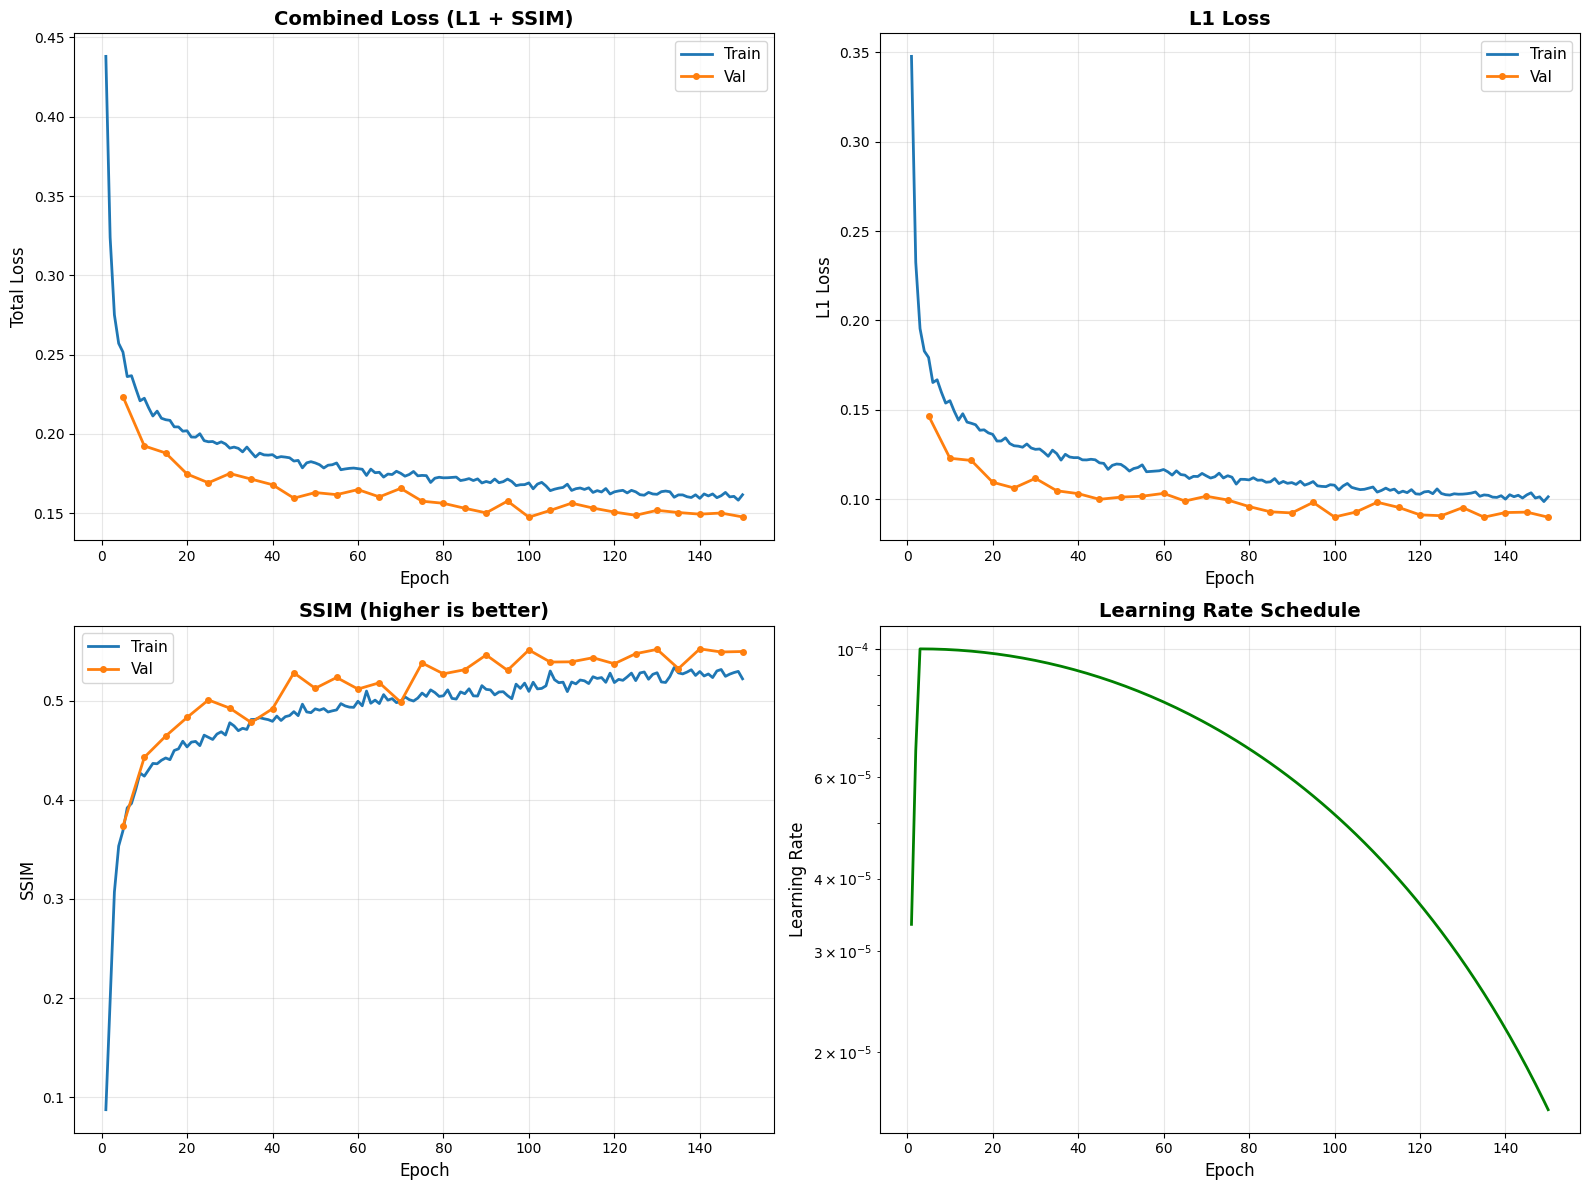


✅ Training curves saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\training_curves.png


In [10]:
# Plot training curves using utility function
plot_training_curves(history=history, save_path=exp_dir / "training_curves.png")

print(f"\n✅ Training curves saved to {exp_dir / 'training_curves.png'}")

## Test Inference on Validation Samples


✅ Loaded best model from epoch 100


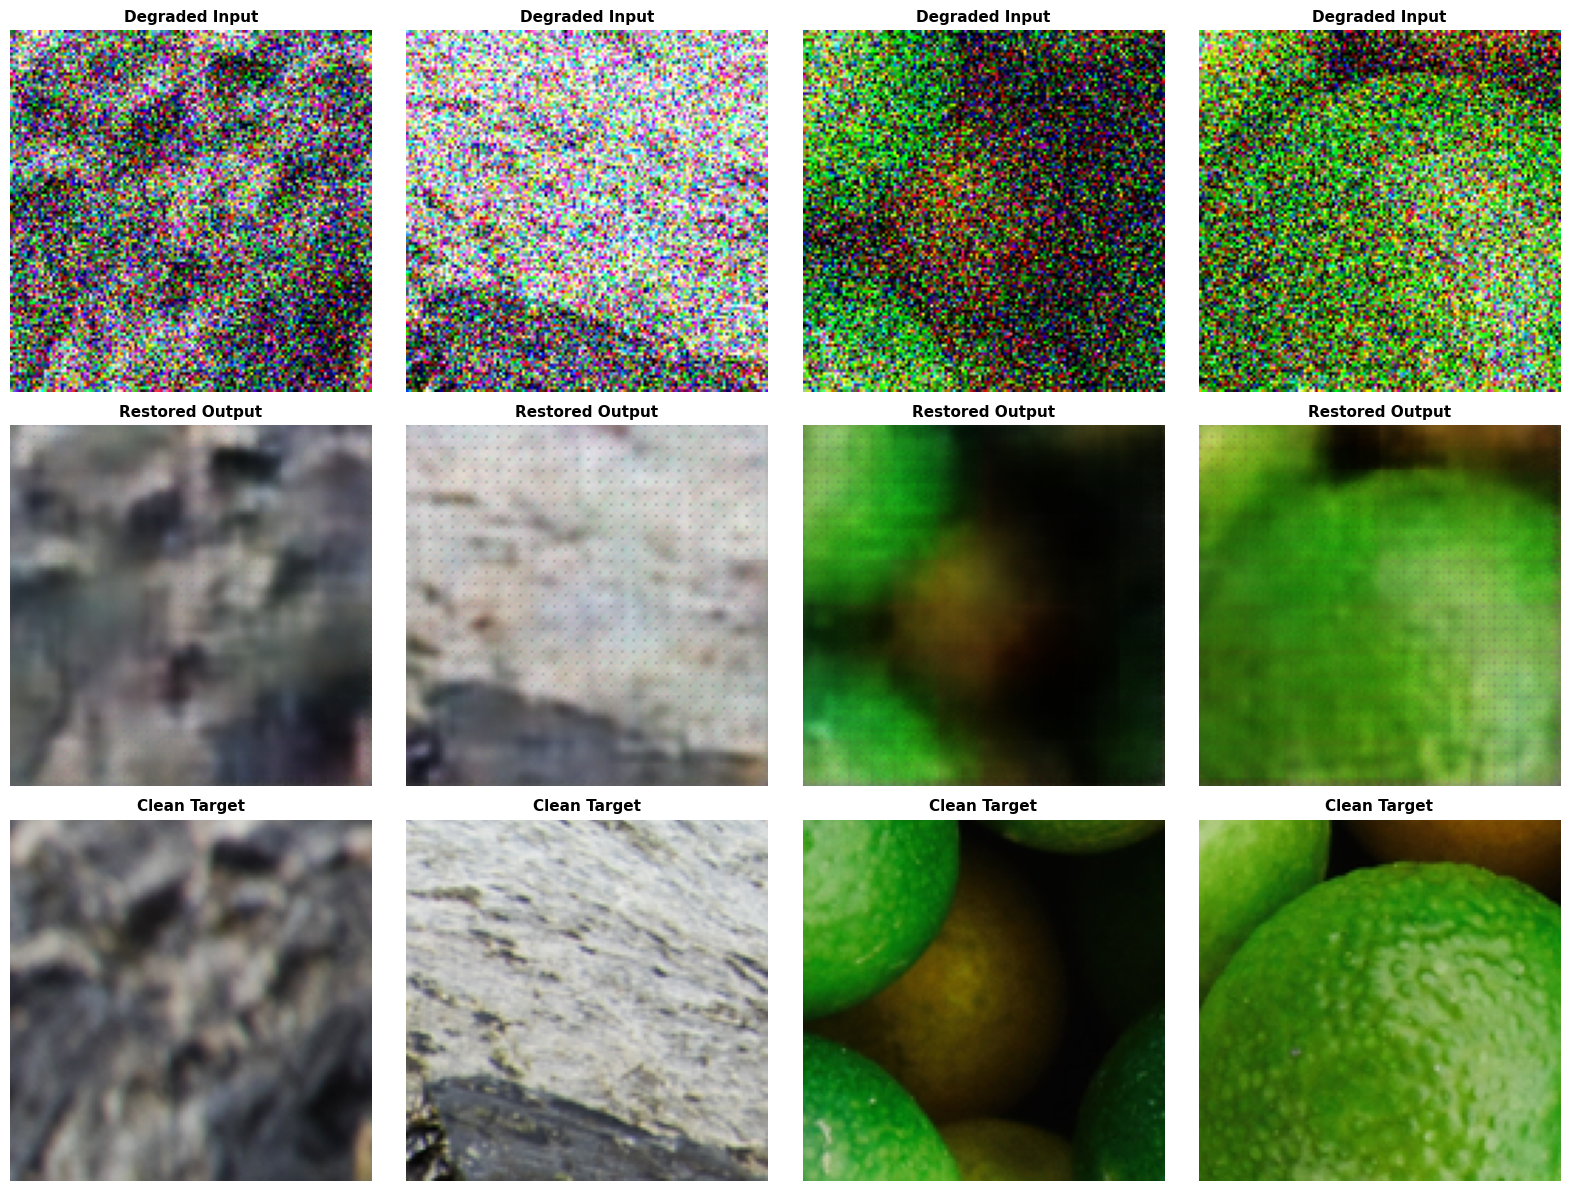


✅ Inference results saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\samples\inference_results.png


In [11]:
# Load best model
checkpoint_info = load_checkpoint(
    checkpoints_dir / "best_model.pth", model=model, device=config["device"]
)

print(f"✅ Loaded best model from epoch {checkpoint_info['epoch']}")

# Get validation batch
degraded_batch, clean_batch = next(iter(val_loader))
degraded_batch = degraded_batch.to(config["device"])
clean_batch = clean_batch.to(config["device"])

# Inference
with torch.no_grad():
    restored_batch = model(degraded_batch)

# Visualize results using utility function
plot_inference_results(
    degraded_batch=degraded_batch,
    restored_batch=restored_batch,
    clean_batch=clean_batch,
    n_samples=4,
    save_path=samples_dir / "inference_results.png",
)

print(f"\n✅ Inference results saved to {samples_dir / 'inference_results.png'}")

## Summary

In [12]:
# Print training summary
print_training_summary(
    history=history,
    best_epoch=best_epoch,
    best_val_loss=best_val_loss,
    exp_dir=exp_dir,
    checkpoints_dir=checkpoints_dir,
    samples_dir=samples_dir,
    logs_dir=logs_dir,
)


📊 TRAINING SUMMARY

Experiment directory: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian

Validation points saved: 150
Best epoch: 100

Best Validation Metrics:
  Loss: 0.1475
  L1: 0.0900
  SSIM: 0.5510

Final Training Metrics:
  Loss: 0.1616
  L1: 0.1013
  SSIM: 0.5219

Performance Statistics:
  Total training time: 0.64h (2301s)
  Total epochs trained: 150
  Avg epoch time: 76.7s
  Avg inference time: 11.3s
  Peak memory: 48MB

Saved files:
  Best model: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\checkpoints\best_model.pth
  Training history: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\history.json
  Training curves: c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\training_curves.png
  Inference samples: c:\uni\Image-Enhancement\experiments\denoisi

## Evaluation on Full-Resolution Images

In [13]:
# Create evaluator
evaluator = ImageRestorationEvaluator(
    model=model,
    device=config["device"],
    patch_size=config["patch_size"],
    overlap=32,  # Overlap for smooth blending
)

print("\n🔍 Evaluator configured:")
print(f"   Patch size: {config['patch_size']}")
print("   Overlap: 32 pixels")
print(f"   Device: {config['device']}")


🔍 Evaluator configured:
   Patch size: 128
   Overlap: 32 pixels
   Device: cuda


In [14]:
# Evaluate on validation set (10 images)
eval_results = evaluator.evaluate_dataset(
    degraded_dir=config["val_degraded_dir"],
    clean_dir=config["val_clean_dir"],
    output_dir=exp_dir / "restored_images",
    save_outputs=True,  # Save restored images
    max_images=10,  # Change to None to evaluate all images
)

# Print summary
evaluator.print_summary(eval_results)

# Save results
evaluator.save_results(eval_results, exp_dir / "evaluation_metrics.json")


📊 Evaluating 10 images...


Processing images:   0%|          | 0/10 [00:00<?, ?it/s]


EVALUATION SUMMARY

📊 Evaluated 10 images

📈 Mean Metrics:
   PSNR: 24.03 ± 2.16 dB
   SSIM: 0.5984 ± 0.0798
   MAE: 0.045701 ± 0.013275
   MSE: 0.004611 ± 0.003240

🏆 Best Image (highest PSNR):
   0802.png
   PSNR: 26.49 dB, SSIM: 0.6824

⚠️  Worst Image (lowest PSNR):
   0807.png
   PSNR: 18.56 dB, SSIM: 0.3887


✅ Results saved to c:\uni\Image-Enhancement\experiments\denoising_autoencoder\gaussian\20260109_120451_autoencoder_gaussian\evaluation_metrics.json


## Visualize evaluation



🏆 Best result: 0802.png
   PSNR: 26.49 dB, SSIM: 0.6824


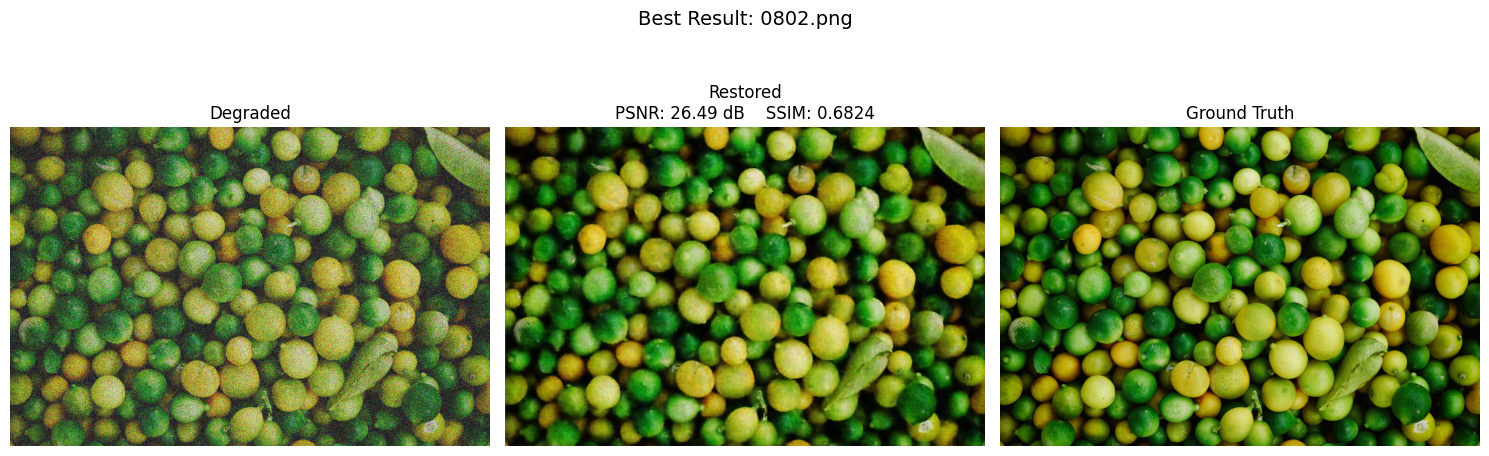


⚠️ Worst result: 0807.png
   PSNR: 18.56 dB, SSIM: 0.3887


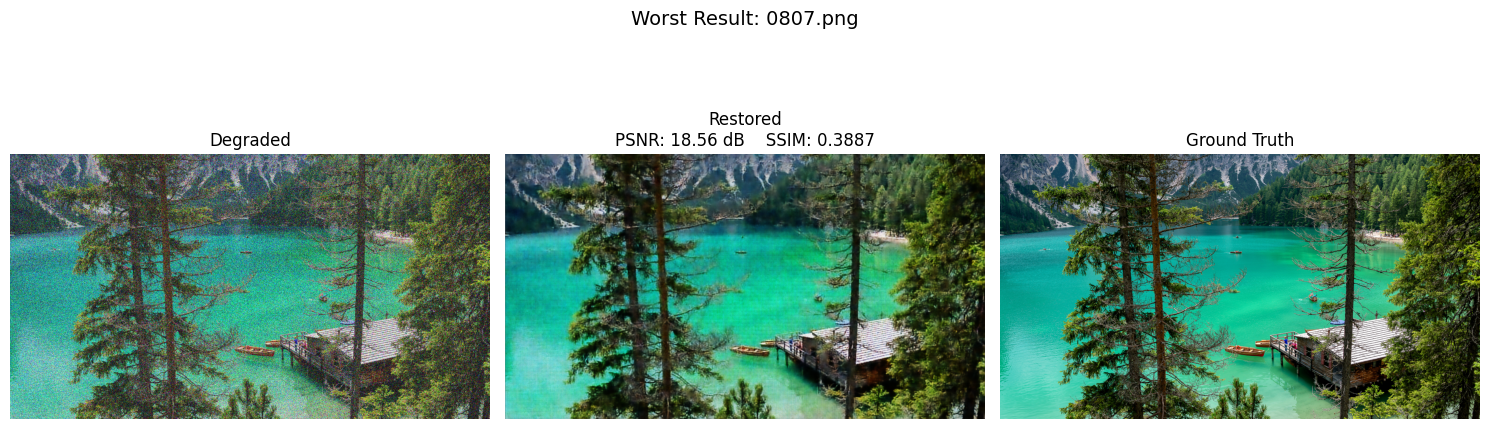

In [15]:
# Get best and worst images
best_img = max(eval_results["per_image"], key=lambda x: x["psnr"])
worst_img = min(eval_results["per_image"], key=lambda x: x["psnr"])


# Load images for visualization
def load_image_trio(filename):
    degraded_path = Path(config["val_degraded_dir"]) / filename
    clean_path = Path(config["val_clean_dir"]) / filename
    restored_path = exp_dir / "restored_images" / filename

    degraded = cv2.cvtColor(cv2.imread(str(degraded_path)), cv2.COLOR_BGR2RGB)
    clean = cv2.cvtColor(cv2.imread(str(clean_path)), cv2.COLOR_BGR2RGB)
    restored = cv2.cvtColor(cv2.imread(str(restored_path)), cv2.COLOR_BGR2RGB)

    return degraded, restored, clean


# Visualize best result
print(f"\n🏆 Best result: {best_img['filename']}")
print(f"   PSNR: {best_img['psnr']:.2f} dB, SSIM: {best_img['ssim']:.4f}")

deg, res, cln = load_image_trio(best_img["filename"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(deg)
axes[0].set_title("Degraded")
axes[0].axis("off")
axes[1].imshow(res)
axes[1].set_title(
    f"Restored\nPSNR: {best_img['psnr']:.2f} dB    SSIM: {best_img['ssim']:.4f}"
)
axes[1].axis("off")
axes[2].imshow(cln)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.suptitle(f"Best Result: {best_img['filename']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(samples_dir / "best_full_restoration.png", dpi=150, bbox_inches="tight")
plt.show()

# Visualize worst result
print(f"\n⚠️ Worst result: {worst_img['filename']}")
print(f"   PSNR: {worst_img['psnr']:.2f} dB, SSIM: {worst_img['ssim']:.4f}")

deg, res, cln = load_image_trio(worst_img["filename"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(deg)
axes[0].set_title("Degraded")
axes[0].axis("off")
axes[1].imshow(res)
axes[1].set_title(
    f"Restored\nPSNR: {worst_img['psnr']:.2f} dB    SSIM: {worst_img['ssim']:.4f}"
)
axes[1].axis("off")
axes[2].imshow(cln)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.suptitle(f"Worst Result: {worst_img['filename']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(samples_dir / "worst_full_restoration.png", dpi=150, bbox_inches="tight")
plt.show()